In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INPUT_ROOT  = "/content/drive/MyDrive/dataset"      # original dataset
OUTPUT_ROOT = "/content/drive/MyDrive/dataset_clean_gray"  # new dataset
ZIP_PATH = "/content/dataset_clean_gray.zip"


In [ ]:
!pip install pillow imagehash opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive, files
import os, shutil, zipfile, random
from PIL import Image
import numpy as np
import cv2
import imagehash
from collections import defaultdict

drive.mount('/content/drive')

# ===== EDIT THESE =====
INPUT_ROOT  = "/content/drive/MyDrive/dataset"          # has train/ and test/
OUTPUT_ROOT = "/content/drive/MyDrive/dataset_gray_bal_2500"  # new folder name
ZIP_PATH    = "/content/dataset_gray_bal_2500.zip"

TOTAL_TRAIN_LIMIT = 2500   # set 2000 or 3000 as you want
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

random.seed(42)
np.random.seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = os.path.join(INPUT_ROOT, "train")
test_dir  = os.path.join(INPUT_ROOT, "test")

# Fix for inconsistent class names in test_dir
test_line_dir_old = os.path.join(test_dir, "line")
test_line_dir_new = os.path.join(test_dir, "line defects")
if os.path.exists(test_line_dir_old) and not os.path.exists(test_line_dir_new):
    os.rename(test_line_dir_old, test_line_dir_new)
    print("Renamed: 'line' -> 'line defects' in test directory for consistency.")

train_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir,d))])
test_classes  = sorted([d for d in os.listdir(test_dir)  if os.path.isdir(os.path.join(test_dir,d))])

print("Train classes:", train_classes)
print("Test classes :", test_classes)

assert train_classes == test_classes, "❌ Train/Test classes mismatch. Make them identical!"
print("✅ Train & Test classes match.")

Renamed: 'line' -> 'line defects' in test directory for consistency.
Train classes: ['BLOCK_ETCH', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'bridge', 'clean', 'line defects', 'others']
Test classes : ['BLOCK_ETCH', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'bridge', 'clean', 'line defects', 'others']
✅ Train & Test classes match.


In [ ]:
if os.path.exists(OUTPUT_ROOT):
    shutil.rmtree(OUTPUT_ROOT)
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("✅ Output folder ready:", OUTPUT_ROOT)


✅ Output folder ready: /content/drive/MyDrive/dataset_gray_bal_2500


In [ ]:
def augment_gray(img):
    h, w = img.shape
    op = random.choice(["flip", "rotate", "noise", "shift"])

    if op == "flip":
        return cv2.flip(img, 1)

    elif op == "rotate":
        angle = random.randint(-15, 15)   # reduced rotation to avoid unrealistic SEM changes
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    elif op == "shift":
        tx = random.randint(-8, 8)
        ty = random.randint(-8, 8)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    else:  # noise
        noise = np.random.normal(0, 8, img.shape).astype(np.float32)
        out = img.astype(np.float32) + noise
        return np.clip(out, 0, 255).astype(np.uint8)


In [ ]:
class_files = defaultdict(list)

for split in ["train", "test"]:
    split_in = os.path.join(INPUT_ROOT, split)
    split_out = os.path.join(OUTPUT_ROOT, split)
    os.makedirs(split_out, exist_ok=True)

    seen_hashes = set()

    for cls in train_classes:
        cls_in = os.path.join(split_in, cls)
        cls_out = os.path.join(split_out, cls)
        os.makedirs(cls_out, exist_ok=True)

        for fn in os.listdir(cls_in):
            if not fn.lower().endswith(IMG_EXTS):
                continue

            in_path = os.path.join(cls_in, fn)
            try:
                img = Image.open(in_path).convert("L")
                hsh = imagehash.phash(img)

                if hsh in seen_hashes:
                    continue
                seen_hashes.add(hsh)

                out_path = os.path.join(cls_out, fn)
                img.save(out_path)
                class_files[(split, cls)].append(out_path)

            except Exception as e:
                print("Skip:", in_path, e)

print("✅ Pass 1 complete: Grayscale + Dedup done.")


✅ Pass 1 complete: Grayscale + Dedup done.


In [ ]:
train_keys = [("train", cls) for cls in train_classes]

counts = {cls: len(class_files[("train", cls)]) for cls in train_classes}
print("Train counts (after dedup):")
for cls in train_classes:
    print(cls, counts[cls])

num_classes = len(train_classes)
max_per_class = TOTAL_TRAIN_LIMIT // num_classes   # e.g. 2500//8 = 312
print("\nTotal train limit:", TOTAL_TRAIN_LIMIT)
print("Max per class allowed:", max_per_class)

# Moderate target: raise only small classes up to 80% of max_per_class
target_floor = int(0.80 * max_per_class)
print("Moderate target floor (80%):", target_floor)


Train counts (after dedup):
BLOCK_ETCH 577
PARTICLE 442
PO_CONTAMINATION 391
SCRATCH 1115
bridge 50
clean 2821
line defects 55
others 657

Total train limit: 2500
Max per class allowed: 312
Moderate target floor (80%): 249


In [ ]:
for cls in train_classes:
    imgs = class_files[("train", cls)]

    # Reduce if too many
    if len(imgs) > max_per_class:
        keep = random.sample(imgs, max_per_class)
        for fp in set(imgs) - set(keep):
            try: os.remove(fp)
            except: pass
        class_files[("train", cls)] = keep
        imgs = keep

    # Augment only if too small
    while len(imgs) < target_floor:
        src_path = random.choice(imgs)
        img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
        aug = augment_gray(img)

        out_folder = os.path.join(OUTPUT_ROOT, "train", cls)
        new_name = f"aug_{len(imgs)}.jpg"
        save_path = os.path.join(out_folder, new_name)
        cv2.imwrite(save_path, aug)
        imgs.append(save_path)

    class_files[("train", cls)] = imgs

print("✅ Moderate balancing complete.")


✅ Moderate balancing complete.


In [ ]:
final_counts = {cls: len(class_files[("train", cls)]) for cls in train_classes}
print("Final TRAIN counts:")
for cls in train_classes:
    print(cls, final_counts[cls])

print("\nTotal TRAIN images:", sum(final_counts.values()))


Final TRAIN counts:
BLOCK_ETCH 312
PARTICLE 312
PO_CONTAMINATION 312
SCRATCH 312
bridge 249
clean 312
line defects 249
others 312

Total TRAIN images: 2370


In [ ]:
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, files_ in os.walk(OUTPUT_ROOT):
        for f in files_:
            fp = os.path.join(root, f)
            z.write(fp, arcname=os.path.relpath(fp, OUTPUT_ROOT))

print("✅ ZIP created:", ZIP_PATH)
files.download(ZIP_PATH)


✅ ZIP created: /content/dataset_gray_bal_2500.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, shutil

DATA_ROOT="/content/drive/MyDrive/dataset_gray_bal_4000"
TRAIN_DIR=os.path.join(DATA_ROOT,"train")
TEST_DIR=os.path.join(DATA_ROOT,"test")

train_classes = set(os.listdir(TRAIN_DIR))
test_classes  = set(os.listdir(TEST_DIR))

print("Train classes:", sorted(train_classes))
print("Test classes :", sorted(test_classes))

# 1) Remove binary folders from test if present
for bad in ["Defective", "Normal"]:
    p=os.path.join(TEST_DIR,bad)
    if os.path.exists(p):
        shutil.rmtree(p)
        print("Removed:", bad)

# 2) Rename 'line' -> 'line defects' if needed
src = os.path.join(TEST_DIR, "line")
dst = os.path.join(TEST_DIR, "line defects")
if os.path.exists(src) and not os.path.exists(dst):
    os.rename(src, dst)
    print("Renamed: line -> line defects")

# 3) Optional: move PIQ_PARTICLE into others (only if you want)
src = os.path.join(TEST_DIR, "PIQ_PARTICLE")
dst = os.path.join(TEST_DIR, "others")
if os.path.exists(src):
    os.makedirs(dst, exist_ok=True)
    for f in os.listdir(src):
        shutil.move(os.path.join(src,f), os.path.join(dst,f))
    shutil.rmtree(src)
    print("Moved PIQ_PARTICLE images -> others")

print("\nAfter fixing:")
print("Test classes:", sorted(os.listdir(TEST_DIR)))


Train classes: ['BLOCK_ETCH', 'COATING_BAD', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'SEZ_BURNT', 'bridge', 'clean', 'gap', 'line defects', 'others']
Test classes : ['BLOCK_ETCH', 'COATING_BAD', 'Defective', 'Normal', 'PARTICLE', 'PIQ_PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'SEZ_BURNT', 'bridge', 'gap', 'line']
Removed: Defective
Removed: Normal
Renamed: line -> line defects
Moved PIQ_PARTICLE images -> others

After fixing:
Test classes: ['BLOCK_ETCH', 'COATING_BAD', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'SEZ_BURNT', 'bridge', 'gap', 'line defects', 'others']


In [ ]:
import os

print("Train classes:")
print(sorted(os.listdir(TRAIN_DIR)))

print("\nTest classes:")
print(sorted(os.listdir(TEST_DIR)))


Train classes:
['BLOCK_ETCH', 'COATING_BAD', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'SEZ_BURNT', 'bridge', 'clean', 'gap', 'line defects', 'others']

Test classes:
['BLOCK_ETCH', 'COATING_BAD', 'Defective', 'Normal', 'PARTICLE', 'PIQ_PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'SEZ_BURNT', 'bridge', 'gap', 'line']


In [ ]:
!pip -q uninstall -y tensorflow-text tf-keras tensorflow-decision-forests ydf || true

# Fix protobuf for TF 2.20
!pip -q install -U "protobuf>=5.28.3"

# Install TensorFlow (Colab will usually keep TF 2.20) + required tools
!pip -q install -U tensorflow scikit-learn seaborn tf2onnx onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-hub 0.16.1 requires tf-keras>=2.14.1, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.
tf2onnx 1.16.1 requires protobuf~=3.20, but you have protobuf 6.33.5 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.5 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.5 which is incompatible.
ERROR: Operation cancelled by user


In [ ]:
import tensorflow as tf
# import tf_keras # This line caused the ModuleNotFoundError

print("TF:", tf.__version__)
print("TF-Keras:", tf.keras.__version__)


TF: 2.19.0
TF-Keras: 3.10.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, tensorflow as tf
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

DATA_ROOT = "/content/drive/MyDrive/dataset_gray_bal_2500"  # <-- change if needed
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

IMG_SIZE = (160, 160)   # RT1170 friendly
BATCH    = 16
SEED     = 42

# enforce same class order
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
NUM_CLASSES = len(class_names)

print("Classes:", NUM_CLASSES, class_names)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: 8 ['BLOCK_ETCH', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'bridge', 'clean', 'line defects', 'others']


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache("/tmp/train_cache").prefetch(AUTOTUNE)
test_ds  = test_ds.cache("/tmp/test_cache").prefetch(AUTOTUNE)


Found 2370 files belonging to 8 classes.
Found 1017 files belonging to 8 classes.


In [ ]:
# ---- Exact preprocessing layer ----
@tf.keras.utils.register_keras_serializable()
def mobilenet_preprocess(x):
    return (x - 127.5) / 127.5

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
], name="augment")

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inp = tf.keras.Input(shape=IMG_SIZE + (3,), name="input")   # name matters for ONNX

x = augment(inp)
x = layers.Lambda(mobilenet_preprocess, name="preprocess")(x)  # <-- exact preprocessing
x = base(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

model = tf.keras.Model(inp, out, name="MobileNetV2_RT1170")
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "MobileNetV2_RT1170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
BEST_KERAS = "/content/mobilenetv2_rt1170_best.keras"

cbs = [
    ModelCheckpoint(BEST_KERAS, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    callbacks=cbs,
    verbose=1
)

print("Best model saved:", BEST_KERAS)


ValueError: You must call `compile()` before using the model.

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 328ms/step


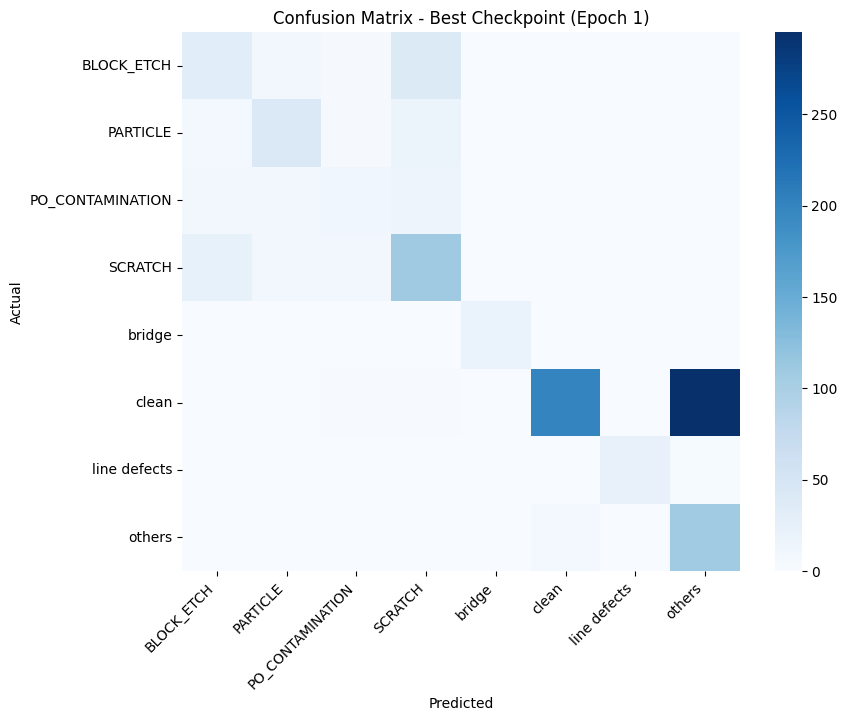

                  precision    recall  f1-score   support

      BLOCK_ETCH     0.4459    0.3837    0.4125        86
        PARTICLE     0.6000    0.5833    0.5915        72
PO_CONTAMINATION     0.3667    0.2391    0.2895        46
         SCRATCH     0.5914    0.7237    0.6509       152
          bridge     1.0000    1.0000    1.0000        19
           clean     0.9662    0.4008    0.5666       499
    line defects     0.9583    0.8846    0.9200        26
          others     0.2678    0.9316    0.4160       117

        accuracy                         0.5379      1017
       macro avg     0.6495    0.6434    0.6059      1017
    weighted avg     0.7332    0.5379    0.5552      1017



In [ ]:
import tensorflow as tf, numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns, matplotlib.pyplot as plt

BEST_KERAS="/content/mobilenetv2_rt1170_best.keras"
best_model = tf.keras.models.load_model(BEST_KERAS, compile=False)

# predict
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = best_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Best Checkpoint (Epoch 1)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [ ]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - MobileNetV2_RT1170")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


ValueError: Input 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 160, 160, 3)

In [ ]:
import tf2onnx, os
import tensorflow as tf

# load best
best_model = tf.keras.models.load_model(BEST_KERAS, compile=False)

ONNX_PATH = "/content/mobilenetv2_rt1170_160.onnx"

# Fixed input signature (batch=1, 160x160x3)
spec = (tf.TensorSpec((1, 160, 160, 3), tf.float32, name="input"),)

model_proto, _ = tf2onnx.convert.from_keras(
    best_model,
    input_signature=spec,
    opset=13,
    output_path=ONNX_PATH
)

print("✅ ONNX saved:", ONNX_PATH)
print("Size (MB):", os.path.getsize(ONNX_PATH)/1024/1024)


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7fe4ef27f4c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ ONNX saved: /content/mobilenetv2_rt1170_160.onnx
Size (MB): 8.539710998535156


In [ ]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

dummy = np.zeros((1,160,160,3), dtype=np.float32)

out = sess.run([output_name], {input_name: dummy})[0]
print("ONNX output shape:", out.shape)  # should be (1, NUM_CLASSES)
print("Sum probs (dummy):", out.sum())


ONNX output shape: (1, 8)
Sum probs (dummy): 1.0


In [ ]:
from google.colab import files
files.download(ONNX_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers

DATA_ROOT="/content/drive/MyDrive/dataset_gray_bal_2500"
TRAIN_DIR=os.path.join(DATA_ROOT,"train")
TEST_DIR=os.path.join(DATA_ROOT,"test")

IMG_SIZE=(160,160)
BATCH=16
SEED=42

class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR,d))])
NUM_CLASSES = len(class_names)
print("Classes:", NUM_CLASSES, class_names)

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, class_names=class_names,
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, class_names=class_names,
    image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False
)

AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache("/tmp/train_cache").prefetch(AUTOTUNE)
test_ds=test_ds.cache("/tmp/test_cache").prefetch(AUTOTUNE)


Classes: 8 ['BLOCK_ETCH', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'bridge', 'clean', 'line defects', 'others']
Found 2370 files belonging to 8 classes.
Found 1017 files belonging to 8 classes.


In [ ]:
augment = tf.keras.Sequential([
    layers.RandomRotation(0.03),   # small
    layers.RandomZoom(0.05),       # small
], name="augment")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def mobilenet_preprocess(x):
    return (x - 127.5) / 127.5

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE+(3,),
    include_top=False,
    weights="imagenet"
)

inp = tf.keras.Input(shape=IMG_SIZE+(3,), name="input")
x = augment(inp)
x = layers.Lambda(mobilenet_preprocess, name="preprocess")(x)  # exact
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

model = tf.keras.Model(inp, out, name="MobileNetV2_RT1170")


In [ ]:
base.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

CKPT1="/content/mnv2_stage1_best.keras"
cbs1=[
    ModelCheckpoint(CKPT1, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1),
]

hist1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cbs1,
    verbose=1
)

print("✅ Stage1 best saved:", CKPT1)


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4622 - loss: 1.4376
Epoch 1: val_accuracy improved from -inf to 0.70108, saving model to /content/mnv2_stage1_best.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 95s 599ms/step - accuracy: 0.4630 - loss: 1.4350 - val_accuracy: 0.7011 - val_loss: 0.7727 - learning_rate: 0.0010
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7085 - loss: 0.7314
Epoch 2: val_accuracy did not improve from 0.70108
149/149 ━━━━━━━━━━━━━━━━━━━━ 130s 516ms/step - accuracy: 0.7085 - loss: 0.7312 - val_accuracy: 0.6765 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7300 - loss: 0.6571
Epoch 3: val_accuracy did not improve from 0.70108

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 509ms/step - accuracy: 0.7302 - loss: 0.6568 - val_accuracy: 0.6676 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 4/5
149/149 ━━━━━━━━

In [ ]:
# load best stage1
model = tf.keras.models.load_model(CKPT1, compile=False)

# Unfreeze ONLY last N layers of base for domain adaptation
base = model.get_layer(index=3)  # base is typically 3rd layer; if error, use model.summary() to confirm

base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

CKPT2="/content/mnv2_finetuned_best.keras"
cbs2=[
    ModelCheckpoint(CKPT2, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

hist2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cbs2,
    verbose=1
)

print("✅ Fine-tuned best saved:", CKPT2)


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6299 - loss: 0.9153
Epoch 1: val_accuracy improved from -inf to 0.76794, saving model to /content/mnv2_finetuned_best.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 112s 675ms/step - accuracy: 0.6303 - loss: 0.9144 - val_accuracy: 0.7679 - val_loss: 0.7088 - learning_rate: 1.0000e-04
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8186 - loss: 0.4698
Epoch 2: val_accuracy improved from 0.76794 to 0.77778, saving model to /content/mnv2_finetuned_best.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 100s 670ms/step - accuracy: 0.8187 - loss: 0.4698 - val_accuracy: 0.7778 - val_loss: 0.6235 - learning_rate: 1.0000e-04
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8908 - loss: 0.3128
Epoch 3: val_accuracy improved from 0.77778 to 0.78958, saving model to /content/mnv2_finetuned_best.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 100s 671ms/step - accuracy: 0.8908 - loss: 0.3128 - val_accuracy: 0.7896 - val_loss: 0.6034

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 328ms/step


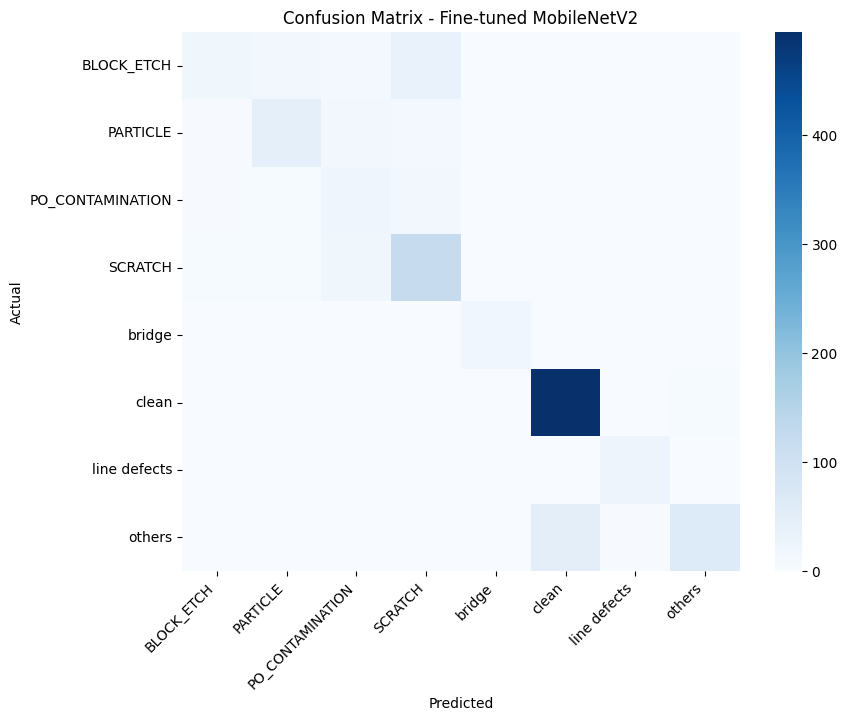

                  precision    recall  f1-score   support

      BLOCK_ETCH     0.7000    0.2442    0.3621        86
        PARTICLE     0.6338    0.6250    0.6294        72
PO_CONTAMINATION     0.3333    0.5000    0.4000        46
         SCRATCH     0.6613    0.8092    0.7278       152
          bridge     1.0000    1.0000    1.0000        19
           clean     0.9099    0.9920    0.9492       499
    line defects     0.8966    1.0000    0.9455        26
          others     0.9420    0.5556    0.6989       117

        accuracy                         0.8033      1017
       macro avg     0.7596    0.7157    0.7141      1017
    weighted avg     0.8144    0.8033    0.7910      1017



In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf

best_model = tf.keras.models.load_model(CKPT2, compile=False)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = best_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-tuned MobileNetV2")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [ ]:
!pip install -U protobuf


  Using cached protobuf-6.33.5-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Using cached protobuf-6.33.5-cp39-abi3-manylinux2014_x86_64.whl (323 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-hub 0.16.1 requires tf-keras>=2.14.1, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.
tf2onnx 1.16.1 requires protobuf~=3.20, but you have protobuf 6.33.5 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.5 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.5 whic

In [ ]:
!pip install tf-keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import onnx
import tf2onnx

# Assuming you've trained your MobileNetV2 model
model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet')

# Define the input signature for the model
spec = (tf.TensorSpec((1, 224, 224, 3), tf.float32, name="input"),)

# Convert the model to ONNX format
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13
)

# Save the ONNX model
onnx.save_model(model_proto, 'mobilenetv2_model.onnx')


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7fe4ef27f4c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


In [ ]:
from google.colab import files
files.download('/content/mobilenetv2_model.onnx')  # Path to your ONNX model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from sklearn.preprocessing import label_binarize

# Assuming your model is already trained and you have the predictions and true labels
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_prob = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# 1. Confusion Matrix Visualization (Save as image)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu', cbar=True, annot_kws={"size": 14},
            xticklabels=class_names, yticklabels=class_names, linewidths=1, linecolor='white')
plt.title('Confusion Matrix - MobileNetV2 (Bright Colors)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Save confusion matrix image
cm_image_path = '/content/confusion_matrix.png'
plt.savefig(cm_image_path)
plt.close()

# Download confusion matrix image
from google.colab import files
files.download(cm_image_path)

# 2. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

# 3. ROC Curve & AUC (Save as image)
# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) - MobileNetV2', fontsize=16)
plt.legend(loc="lower right")

# Save ROC curve image
roc_image_path = '/content/roc_curve.png'
plt.savefig(roc_image_path)
plt.close()

# Download ROC curve image
files.download(roc_image_path)

# 4. AUC Metric
print(f"Model AUC (Area Under Curve): {roc_auc:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Classification Report:
                   precision    recall  f1-score   support

      BLOCK_ETCH     0.4459    0.3837    0.4125        86
        PARTICLE     0.6000    0.5833    0.5915        72
PO_CONTAMINATION     0.3667    0.2391    0.2895        46
         SCRATCH     0.5914    0.7237    0.6509       152
          bridge     1.0000    1.0000    1.0000        19
           clean     0.9662    0.4008    0.5666       499
    line defects     0.9583    0.8846    0.9200        26
          others     0.2678    0.9316    0.4160       117

        accuracy                         0.5379      1017
       macro avg     0.6495    0.6434    0.6059      1017
    weighted avg     0.7332    0.5379    0.5552      1017



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model AUC (Area Under Curve): 0.9301


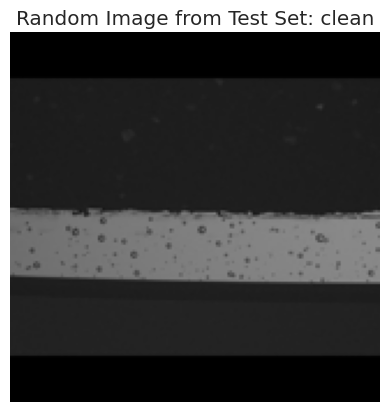

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image

# Pick a random image from the test dataset folder (adjust if necessary)
test_images = []
for cls in class_names:
    cls_folder = os.path.join(TEST_DIR, cls)
    for img_name in os.listdir(cls_folder):
        if img_name.lower().endswith(IMG_EXTS):
            test_images.append(os.path.join(cls_folder, img_name))

# Select a random image path
random_image_path = random.choice(test_images)

# Load the image
img = Image.open(random_image_path)
img = img.convert('RGB')  # Ensure the image is in RGB format
img = img.resize(IMG_SIZE)  # Resize image to match model input

# Show the random image
plt.imshow(img)
plt.title(f"Random Image from Test Set: {random_image_path.split('/')[-2]}")
plt.axis('off')
plt.show()

# Preprocess image (same as training)
img_array = np.array(img)  # Convert to numpy array
img_array = (img_array - 127.5) / 127.5  # Preprocessing (normalize to [-1, 1])
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted class: others (7)
Predicted probabilities: [0.12197018 0.05336196 0.13421406 0.10740402 0.01894899 0.15558612
 0.13103537 0.27747932]


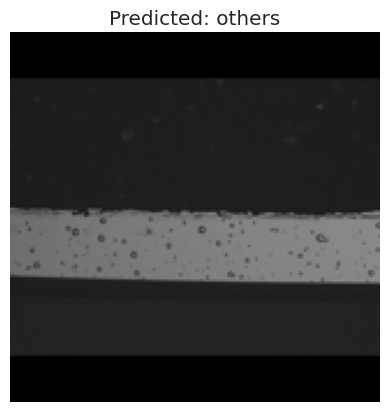

In [ ]:
# Predict the class of the image
predictions = best_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Display the result
print(f"Predicted class: {predicted_class_name} ({predicted_class})")
print("Predicted probabilities:", predictions[0])

# Show the image along with the prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()
